### Delmål 1: Data Exploration & Preprocessing (Uge 1)
**Status:** ⬜ Ikke startet

**Opgaver:**
- [ ] Download MovieLens dataset
- [ ] Exploratory Data Analysis (EDA) i Jupyter notebook
- [ ] Forstå data struktur: users, movies, ratings, timestamps
- [ ] Håndter missing values og outliers
- [ ] Train/validation/test split (70/15/15)
- [ ] Baseline statistik (gennemsnitlig rating, populære film)

**Færdig når:** EDA notebook er komplet med visualiseringer og data er splittet korrekt.


In [20]:
# Packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

## 1. Basic Dataset Overview

**Mål:** Få et overblik over, hvad datasættet indeholder

- Antal rækker i:
  - `ratings`
  - `users` (hvis separat fil)
  - `movies`
- Antal unikke:
  - brugere (`n_users`)
  - film (`n_movies`)
- Sparsity:
  - Formel: $\text{sparsity} = 1 - \frac{\text{antal ratings}}{\text{antal users} \cdot \text{antal movies}}$
- Rating-skala:
  - Minimum, maksimum, gennemsnit, median
  - Tjek om ratings er i trin af 0.5 (fx 0.5, 1.0, 1.5, …)

**Visualiseringer:**

- Histogram af alle ratings
- Lille tabel med:
  - `n_users`, `n_movies`, `n_ratings`, `sparsity`, mean/median rating

---

In [39]:
# Load the data 
ratings = pd.read_csv("data/ratings.csv")

# Antal unikke users og movies 
num_users = len(ratings["userId"].unique())
num_movies = len(ratings["movieId"].unique())
num_ratings = len(ratings["rating"]) 

print("Number of unique users:", num_users)
print("Number of unique movies:", num_movies)

# Sparsity (hvor stor en andel af alle mulige bruger–film-kombinationer, der ikke har en rating)
sparsity = 1 - (num_ratings / (num_users * num_movies))
print(f"The sparsity of the user-movie combinations is: {sparsity:.2f}" )

# ratings min, max, mean, median, steps 
rating_max = ratings["rating"].max()
rating_min = ratings["rating"].min()
rating_mean = ratings["rating"].mean()
rating_median = ratings["rating"].median()
rating_steps = np.sort(ratings["rating"].astype(float).unique())
print(f"Rating max: {rating_max}")
print(f"Rating min: {rating_min}")
print(f"Rating mean: {rating_mean}")
print(f"Rating median: {rating_median}")
print(f"ratings steps: {rating_steps}")

Number of unique users: 610
Number of unique movies: 9724
The sparsity of the user-movie combinations is: 0.98
Rating max: 5.0
Rating min: 0.5
Rating mean: 3.501556983616962
Rating median: 3.5
ratings steps: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


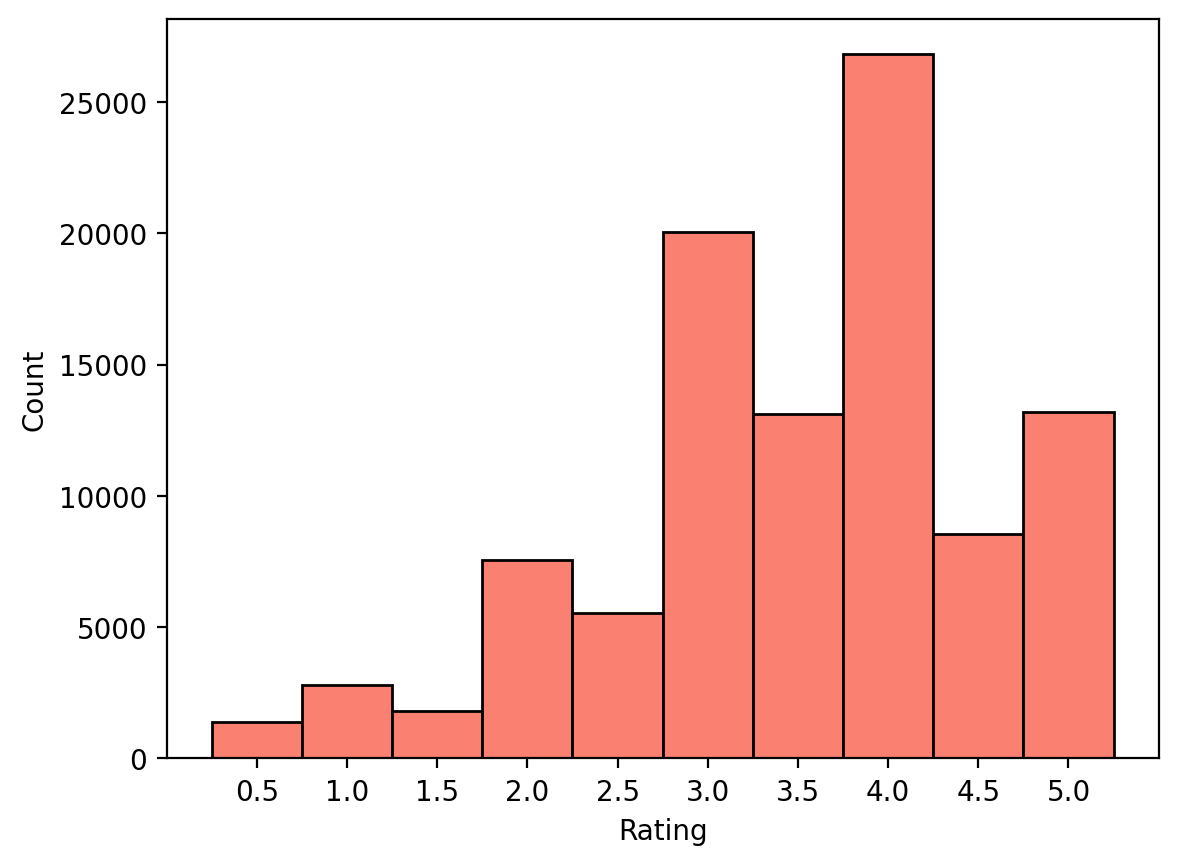

In [ ]:
# Histogram of ratings 
bin_edges = np.append(rating_steps - 0.25, rating_steps[-1] + 0.25)
plt.hist(ratings["rating"], bins=bin_edges, color="salmon", edgecolor="black")
plt.xticks(rating_steps)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## 2. User Behavior

**Mål:** Forstå hvor aktive brugerne er, og hvor mange “svage” brugere der findes (cold-start)

**Per bruger (user):**

- Antal ratings per bruger: `n_ratings_user`
- Gennemsnitlig rating per bruger: `mean_rating_user`
- Evt. standardafvigelse: `std_rating_user`

**Analyser:**

- Histogram af `n_ratings_user`
  - Andel brugere med:
    - mindre end 5 ratings
    - mindre end 10 ratings
- Histogram af `mean_rating_user`
  - Er der mange meget positive/negative brugere?
- Evt. tabel:
  - Gennemsnitligt antal ratings per bruger
  - Median antal ratings per bruger

**Spørgsmål at besvare i teksten:**

- Hvor mange brugere har så få ratings, at de er svære at modellere?
- Overvejer du at filtrere brugere med meget få ratings fra i CF-modellen?

---

In [ ]:
# Antal rating per user
n_ratings_user = ratings.groupby("userId")["rating"].count()
mean_ratings_user = ratings.groupby("userId")["rating"].mean()
std_ratings_user = ratings.groupby("userId")["rating"].std()

# Histogram of n_ratings_user 


userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64
